In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [5]:
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects

import librosa
import tensorflow as tf
import keras
import sklearn

In [6]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"


# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [7]:
sample_lengths = []
folder_path = '/content/drive/MyDrive/LSTM_Emotion_Prediction-main/dataset'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)

    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))

Maximum sample length: 204288


In [8]:
import time
import noisereduce as nr
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []
fileName = []

# Initialize variables
total_length = 204288 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/MyDrive/LSTM_Emotion_Prediction-main/dataset'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.

# Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 5.0)
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed--
    # Pad for duration equalization.
      padded_x = np.pad(xt[:total_length], (0, max(0, total_length - len(xt))), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(y=padded_x,
                          sr=sr)

   # Features extraction
      f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
      f2 = librosa.feature.zero_crossing_rate(y=final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR
      f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]

   # Filling the data lists
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      fileName.append(file)
      #print(file, emotionfix(name))
      emotions.append(emotionfix(name))

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 33.3081 minutes


In [9]:

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (8484, 400, 1)
RMS shape: (8484, 400, 1)
MFCCs shape: (8484, 400, 13)


In [10]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [11]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.224, random_state = 1,shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1,shuffle=True)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [12]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))
print(np.shape(Y))

(6583, 400, 15)
(1323, 400, 15)
(578, 400, 15)
(8484, 1)


In [13]:
import os
from json_tricks import load

import numpy as np

import librosa
from pydub import AudioSegment, effects
import noisereduce as nr

import tensorflow as tf
import keras
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

In [14]:
saved_model_path  = f'/content/drive/MyDrive/LSTM_Emotion_Prediction-main/model.json'
saved_weights_path = f'/content/drive/MyDrive/LSTM_Emotion_Prediction-main/model_weights.h5'
#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 64)           20480     
                                                                 
 dropout (Dropout)           (None, 400, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54024 (211.03 KB)
Trainable params: 54024 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [15]:
# Validation score
print("Evaluate data size : " , np.shape(x_val)[0])
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)
print("Accuracy", str(acc * 100) + "%")

Evaluate data size :  1323
42/42 - 5s - loss: 0.1878 - categorical_accuracy: 0.9471 - 5s/epoch - 124ms/step
Accuracy 94.70899701118469%


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

42/42 [==============================] - 4s 88ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

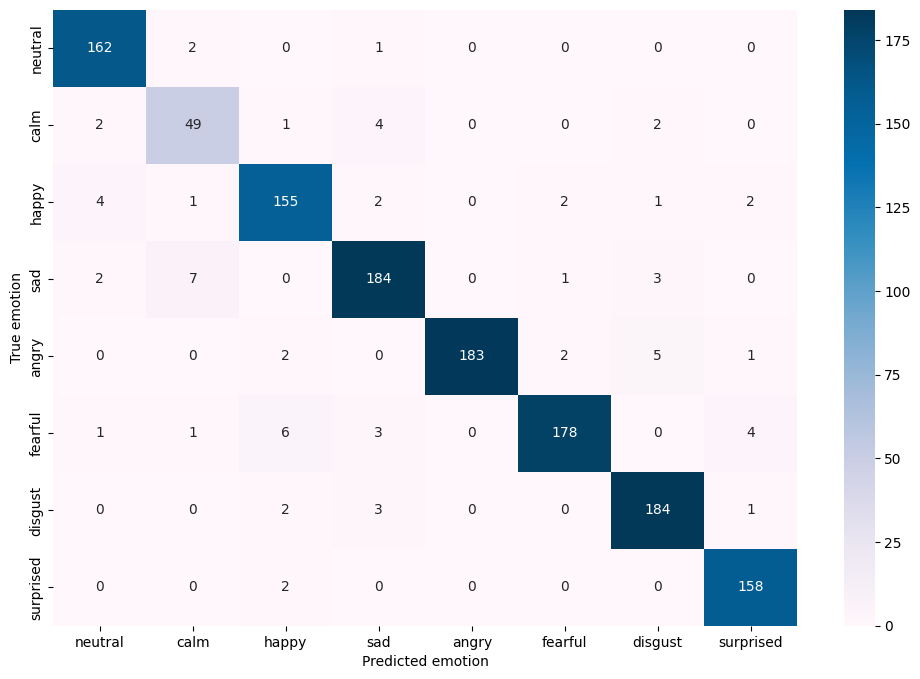

In [17]:
# Validation Confusion matrix
import pandas as pd
y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [18]:
values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.9818
calm : 0.8448
happy : 0.9281
sad : 0.9340
angry : 0.9482
fearful : 0.9223
disgust : 0.9684
surprised : 0.9875


In [19]:
print(x_val[0][3],y_val_class[3])

[ 2.2460938e-01  1.1282461e+02  4.8059811e+02 -6.9133148e+01
 -5.8030457e+01  6.1337833e+01  1.3501402e+01  5.2824755e+00
 -4.6575073e+01  2.2546213e+01  5.8358517e+00 -2.7454367e+00
 -5.6729279e+00 -2.0332806e+01  1.3658529e+01] 5


In [20]:
predictions = model.predict(x_val, use_multiprocessing=True)

42/42 [==============================] - 4s 89ms/step


In [21]:
predictions.shape

(1323, 8)

In [22]:
x_val.shape

(1323, 400, 15)

In [23]:
np.argmax(predictions[3])

5

In [24]:
emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad', #SAD
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'
}
emo_list = list(emotions.values())

In [25]:
def preprocess(file_path, subdir):
    rms_t = []
    zcr_t = []
    mfcc_t = []

    _, sr = librosa.load(path = os.path.join(subdir,file_path), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
    rawsound = AudioSegment.from_file( os.path.join(subdir,file_path))
    # Normalize the audio to +5.0 dBFS.
    normalizedsound = effects.normalize(rawsound, headroom = 5.0)
    # Transform the normalized audio to np.array of samples.
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
    xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed--
    # Pad for duration equalization.
    padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
    # Noise reduction.
    final_x = nr.reduce_noise(y=padded_x,
                          sr=sr)

   # Features extraction
    f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(y=final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR
    f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

   # Emotion extraction from the different databases
    if (find_emotion_T(file_path) != "-1"): #TESS database validation
        name = find_emotion_T(file_path)
    else:                              #RAVDESS database validation
        name = file_path[6:8]

   # Filling the data lists
    rms_t.append(f1)
    zcr_t.append(f2)
    mfcc_t.append(f3)

    f_rms_t = np.asarray(rms_t).astype('float32')
    f_rms_t = np.swapaxes(f_rms_t,1,2)
    f_zcr_t = np.asarray(zcr_t).astype('float32')
    f_zcr_t = np.swapaxes(f_zcr_t,1,2)
    f_mfccs_t = np.asarray(mfcc_t).astype('float32')
    f_mfccs_t = np.swapaxes(f_mfccs_t,1,2)

    #print(file, emotionfix(name))


    X = np.concatenate((f_zcr_t, f_rms_t, f_mfccs_t), axis=2)

    predictions = model.predict(X, use_multiprocessing=True)

    y_pred_class = np.argmax(predictions)
    print("file : " + str(file_path), ",Real emotion : " + str(emotionfix(name)) + " " + emotions.get(emotionfix(name),-1), ",predictions : " + str(y_pred_class)+ " " +emotions.get(y_pred_class,-1))
    return y_pred_class


In [26]:
a = preprocess('03-01-01-01-01-01-02.wav','/content/drive/MyDrive/LSTM_Emotion_Prediction-main/dataset/Actor_02')

1/1 [==============================] - 0s 71ms/step
file : 03-01-01-01-01-01-02.wav ,Real emotion : 0 neutral ,predictions : 0 neutral


In [27]:
a

0

In [29]:
folder_path = '/content/drive/MyDrive/LSTM_Emotion_Prediction-main/dataset/Actor_01'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:
    b = preprocess(file,subdir)

1/1 [==============================] - 0s 97ms/step
file : 03-01-01-01-01-01-01.wav ,Real emotion : 0 neutral ,predictions : 0 neutral
1/1 [==============================] - 0s 104ms/step
file : 03-01-02-01-01-02-01 (1).wav ,Real emotion : 1 calm ,predictions : 6 disgust
1/1 [==============================] - 0s 161ms/step
file : 03-01-02-01-01-01-01 (1).wav ,Real emotion : 1 calm ,predictions : 3 sad
1/1 [==============================] - 0s 188ms/step
file : 03-01-01-01-02-02-01 (1).wav ,Real emotion : 0 neutral ,predictions : 0 neutral
1/1 [==============================] - 0s 121ms/step
file : 03-01-01-01-01-02-01.wav ,Real emotion : 0 neutral ,predictions : 0 neutral
1/1 [==============================] - 0s 99ms/step
file : 03-01-01-01-02-01-01.wav ,Real emotion : 0 neutral ,predictions : 0 neutral
1/1 [==============================] - 0s 96ms/step
file : 03-01-02-01-02-01-01 (1).wav ,Real emotion : 1 calm ,predictions : 0 neutral
1/1 [==============================] - 0s 108ms/

In [1]:
!pip install pyaudio

In [28]:
import os
from json_tricks import load
import pyaudio
import wave
from array import array
import struct
import time
from datetime import datetime
import shutil
import numpy as np
import librosa
from pydub import AudioSegment, effects
import noisereduce as nr


In [34]:
saved_model_path = 'D:/1. KULIAH/SEMESTER 5/STKI/checkpoint 1/model.json'
saved_weights_path = 'D:/1. KULIAH/SEMESTER 5/STKI/checkpoint 1/model_weights.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 64)           20480     
                                                                 
 dropout (Dropout)           (None, 400, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54024 (211.03 KB)
Trainable params: 54024 (211.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [35]:
def voice_predictions():



    
    RATE = 24414
    CHUNK = 512
    RECORD_SECONDS = 7
    FORMAT = pyaudio.paInt32
    CHANNELS = 1

    # Initialize variables
    total_length = 204288 # desired frame length for all of the audio samples.
    frame_length = 2048
    hop_length = 512
    WAVE_OUTPUT_FILE = "D:/1. KULIAH/SEMESTER 5/STKI/checkpoint 1/output_testing.wav"
    WAVE_OUTPUT_FILENAME_TESTING = "D:/1. KULIAH/SEMESTER 5/STKI/checkpoint 1/dataset/Actor_02/03-01-01-01-01-01-02.wav"

    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

    data = array('h', np.random.randint(size = 512, low = 0, high = 500))

    print("** Analysis started")
    total_predictions = [] # A list for all predictions in the session.
    tic = time.perf_counter()


    print("* Analysis...")
    frames = []
    data = np.nan # Reset 'data' variable.

    timesteps = int(RATE / CHUNK * RECORD_SECONDS) # => 339

    # Insert frames to 'output.wav'.
    for i in range(0, timesteps):
        data = array('l', stream.read(CHUNK))
        frames.append(data)

        wf = wave.open(WAVE_OUTPUT_FILE, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

    print("* done Analysis")

    rms_t = []
    zcr_t = []
    mfcc_t = []

    _, sr = librosa.load(path = WAVE_OUTPUT_FILENAME_TESTING, sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
    rawsound = AudioSegment.from_file(WAVE_OUTPUT_FILENAME_TESTING)
    # Normalize the audio to +5.0 dBFS.
    normalizedsound = effects.normalize(rawsound, headroom = 0)
    # Transform the normalized audio to np.array of samples.
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
    xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed--
    # Pad for duration equalization.
    padded_x = np.pad(xt, (0, 204288-len(xt)), 'constant')
    # Noise reduction.
    final_x = nr.reduce_noise(y=padded_x,
                          sr=sr)

    # Features extraction
    f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(y=final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR
    f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

    # Filling the data lists
    rms_t.append(f1)
    zcr_t.append(f2)
    mfcc_t.append(f3)

    f_rms_t = np.asarray(rms_t).astype('float32')
    f_rms_t = np.swapaxes(f_rms_t,1,2)
    f_zcr_t = np.asarray(zcr_t).astype('float32')
    f_zcr_t = np.swapaxes(f_zcr_t,1,2)
    f_mfccs_t = np.asarray(mfcc_t).astype('float32')
    f_mfccs_t = np.swapaxes(f_mfccs_t,1,2)

    #print(file, emotionfix(name))


    X = np.concatenate((f_zcr_t, f_rms_t, f_mfccs_t), axis=2)

    predictions = model.predict(X, use_multiprocessing=True)

    y_pred_class = np.argmax(predictions)
    print("predictions : " + str(y_pred_class)+ " " +emotions.get(y_pred_class))


    pred_list = list(predictions)
    pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statments.
    total_predictions.append(pred_np)
    print(pred_list)
    fig = plt.figure(figsize = (10, 2))
    plt.bar(emo_list, pred_np, color = 'darkturquoise')
    plt.ylabel("Probabilty (%)")
    plt.show()


    return predictions

In [37]:
# Emotions list is created for a readable form of the model prediction.

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100


** Analysis started
* Analysis...
* done Analysis
1/1 [==============================] - 0s 34ms/step
predictions : 0 neutral
[array([9.23685431e-01, 1.14215789e-02, 3.52333002e-02, 1.19822575e-02,
       1.68211220e-04, 3.17504746e-03, 4.39478550e-04, 1.38946995e-02],
      dtype=float32)]


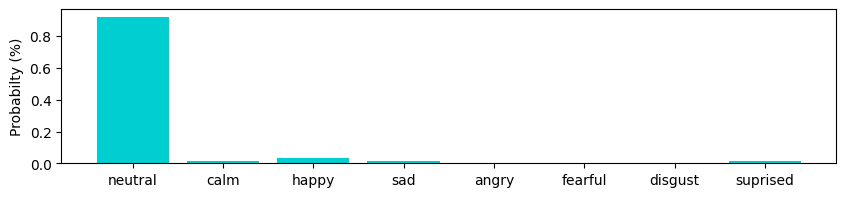

array([[9.23685431e-01, 1.14215789e-02, 3.52333002e-02, 1.19822575e-02,
        1.68211220e-04, 3.17504746e-03, 4.39478550e-04, 1.38946995e-02]],
      dtype=float32)

In [39]:
ABC = voice_predictions()
ABC